In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

import torch
import spacy
from torch import nn, optim
from transformers import pipeline
from functools import partial

nlp = spacy.load("en_core_web_trf")

/home/ytchen/.local/lib/python3.8/site-packages/spacy/util.py:730: UserWarning: [W095] Model 'en_core_web_trf' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.1.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [22]:
imdb_data=pd.read_csv('./data/pruned_train.csv')
print(imdb_data.shape)
imdb_data.head(5)

(29341, 5)


,ID,review,sentiment,processed_review,pruned_review
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...,river phoenix joaquin phoenix embarrasing weir...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...,usually great crazy pretty mr jones different ...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre,bad mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...,ago single good close wonderfuly original usua...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...,wrong wrong myers ago cutesy painfully unfunny...


In [45]:
imdb_test_data=pd.read_csv('./data/processed_test.csv')
print(imdb_test_data.shape)
imdb_test_data.head(5)

(29341, 3)


,ID,review,processed_review
0,22622,Robert Lansing plays a scientist experimenting...,robert lansing play scientist experiment pass ...
1,10162,"Well I've enjoy this movie, even though someti...",ve enjoy movie turn stereotypical situation nt...
2,17468,First things first - though I believe Joel Sch...,thing believe joel schumacher well mediocre di...
3,42579,I watched this movie on the grounds that Amber...,watch movie ground amber benson rock nick stah...
4,701,A certain sexiness underlines even the dullest...,certain sexiness underline dull tangent


In [24]:
MAX_LEN = 512

In [5]:
all_review = list(map(str, np.concatenate([imdb_data.processed_review.values, imdb_test_data.processed_review.values])))
train_review = list(map(str, imdb_data.processed_review.values))
test_review = list(map(str, imdb_test_data.processed_review.values))

#### produce column : pruned_review

if input documents are longer than 512 tokens, sentiment analysis pipeline is not out of box. so, we need to prune reviews first. 

Our preprocessing pipeline : tokenize -> remove stopwords -> choose words where pos like adj, adv, propn etc., these words are representative.


In [6]:
def prune_text(text, MAX_LEN):
    doc = nlp(text)
    lst = []
    for token in doc:
        # print(token, token.pos_)
        if token.pos_ in ('ADJ','ADV','CONJ','CCONJ','PART','PROPN'):
            lst.append(token.orth_)
    if len(lst) > MAX_LEN:
        lst = lst[:MAX_LEN]

    return " ".join(lst)

# processed_text = list(map(partial(prune_text, MAX_LEN=MAX_LEN), list(train_review)))
# imdb_data['pruned_review'] = processed_text
# imdb_data.to_csv('./data/processed_train.csv',index=0)

# processed_text = list(map(partial(prune_text, MAX_LEN=MAX_LEN), list(test_review)))
# imdb_test_data['pruned_review'] = processed_text
# imdb_data.to_csv('./data/processed_test.csv',index=0)

In [7]:
# https://towardsdatascience.com/sentiment-analysis-with-pretrained-transformers-using-pytorch-420bbc1a48cd
sentiment_analysis = pipeline("sentiment-analysis")

In [8]:
results = sentiment_analysis(["We are very happy to show you the 🤗 Transformers library.",
           "We hope you don't hate it."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.5309


In [9]:
s = "I'm extremely excited but today weather is not good."
print(s)
sentiment_analysis(s)[0]

I'm extremely excited but today weather is not good.


{'label': 'NEGATIVE', 'score': 0.9990981817245483}

In [10]:
s1 = prune_text(s, MAX_LEN=MAX_LEN)
print(s1)
sentiment_analysis(s1)[0]

extremely excited but not good


{'label': 'NEGATIVE', 'score': 0.9929606914520264}

In [25]:
imdb_data['processed_review'] = imdb_data['processed_review'].astype(str)

In [26]:
%%time
imdb_data['processed_review_pruned_length'] = imdb_data['processed_review'].apply(lambda x : " ".join(x.split( )[:MAX_LEN]))

CPU times: user 344 ms, sys: 12 ms, total: 356 ms
Wall time: 355 ms


In [27]:
imdb_data

,ID,review,sentiment,processed_review,pruned_review,processed_review_pruned_length
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...,river phoenix joaquin phoenix embarrasing weir...,watch film m big fan river phoenix joaquin pho...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...,usually great crazy pretty mr jones different ...,movie manage lot people see place bump acciden...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre,bad mediocre,bad movie mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...,ago single good close wonderfuly original usua...,friend rent night ago single good movie see me...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...,wrong wrong myers ago cutesy painfully unfunny...,movie wrong wrong wrong mike myers example s r...
...,...,...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood,honest hollywood,s honest film hollywood
29337,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama,absorb unsettling psychological,absorb unsettling psychological drama
29338,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...,soylent green good actually heston sneery invi...,soylent green good movie actually ve think don...
29339,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...,isn funny stupid good loud maybe funny flat ma...,isn funny spot disappoint love stupid movie ex...


In [28]:
# imdb_data.to_csv('./data/pruned_train.csv', index=0)

In [29]:
# filtered weird sentiment data
imdb_data = imdb_data[~imdb_data['sentiment'].str.contains(r'[^0-9]')]
imdb_data = imdb_data[~imdb_data['sentiment'].str.contains('[A-Za-z]')]

In [30]:
imdb_data['sentiment'] = imdb_data['sentiment'].astype(np.int8)
imdb_data['processed_review_pruned_length'] = imdb_data['processed_review_pruned_length'].astype(str)

imdb_data.reset_index(drop=True, inplace=True)

<AxesSubplot:>

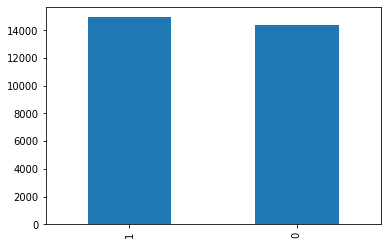

In [31]:
imdb_data.sentiment.value_counts().plot(kind='bar')

In [32]:
imdb_data

,ID,review,sentiment,processed_review,pruned_review,processed_review_pruned_length
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...,river phoenix joaquin phoenix embarrasing weir...,watch film m big fan river phoenix joaquin pho...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...,usually great crazy pretty mr jones different ...,movie manage lot people see place bump acciden...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre,bad mediocre,bad movie mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...,ago single good close wonderfuly original usua...,friend rent night ago single good movie see me...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...,wrong wrong myers ago cutesy painfully unfunny...,movie wrong wrong wrong mike myers example s r...
...,...,...,...,...,...,...
29298,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood,honest hollywood,s honest film hollywood
29299,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama,absorb unsettling psychological,absorb unsettling psychological drama
29300,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...,soylent green good actually heston sneery invi...,soylent green good movie actually ve think don...
29301,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...,isn funny stupid good loud maybe funny flat ma...,isn funny spot disappoint love stupid movie ex...


In [35]:
%%time

result = []
score = []
for txt in tqdm(imdb_data['processed_review_pruned_length']):
    try:
        result.append('0' if sentiment_analysis(txt)[0]['label'] == 'NEGATIVE' else '1')
        score.append(sentiment_analysis(txt)[0]['score'])
    except:
        result.append('1')
        score.append(0.0)

100%|██████████| 29303/29303 [49:40<00:00,  9.83it/s]

CPU times: user 3h 16min 47s, sys: 43.5 s, total: 3h 17min 31s
Wall time: 49min 40s


In [37]:
imdb_data['pred_sentiment'] = result
imdb_data['score'] = score

In [39]:
imdb_data

,ID,review,sentiment,processed_review,pruned_review,processed_review_pruned_length,pred_sentiment,score
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...,river phoenix joaquin phoenix embarrasing weir...,watch film m big fan river phoenix joaquin pho...,0,0.986592
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...,usually great crazy pretty mr jones different ...,movie manage lot people see place bump acciden...,1,0.986148
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre,bad mediocre,bad movie mediocre,0,0.999803
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...,ago single good close wonderfuly original usua...,friend rent night ago single good movie see me...,1,0.591410
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...,wrong wrong myers ago cutesy painfully unfunny...,movie wrong wrong wrong mike myers example s r...,0,0.999618
...,...,...,...,...,...,...,...,...
29298,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood,honest hollywood,s honest film hollywood,1,0.999844
29299,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama,absorb unsettling psychological,absorb unsettling psychological drama,0,0.970516
29300,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...,soylent green good actually heston sneery invi...,soylent green good movie actually ve think don...,1,0.985238
29301,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...,isn funny stupid good loud maybe funny flat ma...,isn funny spot disappoint love stupid movie ex...,0,0.995336


In [41]:
from sklearn.metrics import accuracy_score, classification_report

imdb_data['pred_sentiment'] = imdb_data['pred_sentiment'].astype(np.int8)

print(accuracy_score(imdb_data['sentiment'], imdb_data['pred_sentiment']))

0.8055830461044944


In [42]:
print(classification_report(imdb_data['sentiment'], imdb_data['pred_sentiment']))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81     14368
           1       0.86      0.74      0.80     14935

    accuracy                           0.81     29303
   macro avg       0.81      0.81      0.81     29303
weighted avg       0.81      0.81      0.80     29303



In [43]:
# imdb_data.to_csv('data/pruned_review.csv', index=0)

## Test data

In [46]:
imdb_test_data

,ID,review,processed_review
0,22622,Robert Lansing plays a scientist experimenting...,robert lansing play scientist experiment pass ...
1,10162,"Well I've enjoy this movie, even though someti...",ve enjoy movie turn stereotypical situation nt...
2,17468,First things first - though I believe Joel Sch...,thing believe joel schumacher well mediocre di...
3,42579,I watched this movie on the grounds that Amber...,watch movie ground amber benson rock nick stah...
4,701,A certain sexiness underlines even the dullest...,certain sexiness underline dull tangent
...,...,...,...
29336,30370,It is difficult to rate a writer/director's fi...,difficult rate writer director s effort movie ...
29337,18654,"After watching this movie once, it quickly bec...",watch movie quickly favorite different event h...
29338,47985,"Even though i sat and watched the whole thing,...",sit watch thing good place big chunk informati...
29339,9866,Warning Spoilers following. Superb recreation ...,warn spoiler follow superb recreation base ant...


In [48]:
%%time
imdb_test_data['processed_review'] = imdb_test_data['processed_review'].astype(str)

imdb_test_data['processed_review_pruned_length'] = imdb_test_data['processed_review'].apply(lambda x : " ".join(x.split( )[:MAX_LEN]))

imdb_test_data['processed_review_pruned_length'] = imdb_test_data['processed_review_pruned_length'].astype(str)
    

CPU times: user 452 ms, sys: 8 ms, total: 460 ms
Wall time: 458 ms


In [49]:
%%time

result1 = []
score1 = []

for txt in tqdm(imdb_test_data['processed_review_pruned_length']):
    try:
        result1.append('0' if sentiment_analysis(txt)[0]['label'] == 'NEGATIVE' else '1')
        score1.append(sentiment_analysis(txt)[0]['score'])
    except:
        result1.append('1')
        score1.append(0.0)

100%|██████████| 29341/29341 [1:39:50<00:00,  4.90it/s]

CPU times: user 6h 20min 57s, sys: 1min 31s, total: 6h 22min 29s
Wall time: 1h 39min 50s


In [50]:
imdb_test_data['pred_sentiment'] = result1
imdb_test_data['score'] = score1
imdb_test_data

,ID,review,processed_review,processed_review_pruned_length,pred_sentiment,score
0,22622,Robert Lansing plays a scientist experimenting...,robert lansing play scientist experiment pass ...,robert lansing play scientist experiment pass ...,0,0.966646
1,10162,"Well I've enjoy this movie, even though someti...",ve enjoy movie turn stereotypical situation nt...,ve enjoy movie turn stereotypical situation nt...,0,0.972221
2,17468,First things first - though I believe Joel Sch...,thing believe joel schumacher well mediocre di...,thing believe joel schumacher well mediocre di...,0,0.993100
3,42579,I watched this movie on the grounds that Amber...,watch movie ground amber benson rock nick stah...,watch movie ground amber benson rock nick stah...,0,0.990918
4,701,A certain sexiness underlines even the dullest...,certain sexiness underline dull tangent,certain sexiness underline dull tangent,0,0.995758
...,...,...,...,...,...,...
29336,30370,It is difficult to rate a writer/director's fi...,difficult rate writer director s effort movie ...,difficult rate writer director s effort movie ...,0,0.969178
29337,18654,"After watching this movie once, it quickly bec...",watch movie quickly favorite different event h...,watch movie quickly favorite different event h...,1,0.987217
29338,47985,"Even though i sat and watched the whole thing,...",sit watch thing good place big chunk informati...,sit watch thing good place big chunk informati...,0,0.990945
29339,9866,Warning Spoilers following. Superb recreation ...,warn spoiler follow superb recreation base ant...,warn spoiler follow superb recreation base ant...,0,0.988599


In [51]:
# imdb_test_data.to_csv('pruned_test.csv', index=0)

In [52]:
submission = imdb_test_data[['ID', 'pred_sentiment']]
submission.rename({'pred_sentiment':'sentiment'}, axis=1,inplace=True)
submission.to_csv('./data/processed_baseline_submission.csv', index=0)

/home/ytchen/.local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [53]:
submission

,ID,sentiment
0,22622,0
1,10162,0
2,17468,0
3,42579,0
4,701,0
...,...,...
29336,30370,0
29337,18654,1
29338,47985,0
29339,9866,0
